In [1]:
import os
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def transaction_parameters_given_average_ticket_value(atv, std):
    """Returns the shape and rate parameters of a Gamma distribution given known values for average ticket value and its standard deviation (spread)."""
    
    # just rewriting parameters to be explicit with dependencies on ratio among location / dispersion statistics
    coeff_of_var = std / atv
    dispersion_index = (std ** 2) / atv

    # these come from the relationship between the mean and variance of a Gamma distribution
    alpha = 1 / (coeff_of_var ** 2)
    beta = 1 / dispersion_index
    return alpha, beta


def atv_and_std_from_transaction_parameters(alpha, beta):
    """Returns the average ticket value and its standard deviation given the shape and rate parameters of a Gamma distribution."""
    
    atv = alpha / beta
    std = np.sqrt(alpha) / beta
    return atv, std

def conversion_params_given_true_p(true_p, num_samples=2, alpha_0=1, beta_0=1):
    """Returns the alpha and beta parameters of a Beta distribution given the true conversion probability.  
    Num_samples proxies a precision of the beta distribution (alpha + beta).
    alpha_0 and beta_0 are the prior parameters of the Beta distribution.
    """
    num_success = num_samples * true_p
    num_fails = num_samples - num_success
    
    alpha = num_success + alpha_0
    beta = num_fails + beta_0

    return alpha, beta

In [3]:
# true values: average ticket value and standard deviation of it + Gamma priors of the variable
atv = np.array([50, 51, 49])
std = np.array([100, 100, 100])
alpha_revenue, beta_revenue = transaction_parameters_given_average_ticket_value(atv, std)

# true values: conversion rates
p_true = np.array([0.10, 0.10, 0.10])  # index 0 is control; others are treatment variants

# sample sizes and weights
n_total = 100000
weights_true = np.array([0.33, 0.33, 0.33])  # weights for control and treatment variants
weights_true /= weights_true.sum() # normalize weights
group_labels = ['control'] + [f'treatment_{i}' for i in range(1, len(weights_true))]
n_samples = (weights_true * n_total).astype(int)

# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# MCMC parameters
n_cores = os.cpu_count()
print(f"n_cores: {n_cores}")
n_chains = n_cores
n_tune = 500
n_draws_per_chain = 1000


n_cores: 8


In [4]:
# non informative priors
p_alpha_0 = 1
p_beta_0 = 1
mu_rev_mu0 = 0
mu_rev_std0 = 100
std_rev_std0 = 100

In [5]:
# better priors

p_alpha_0, p_beta_0 = conversion_params_given_true_p(0.02, num_samples=100, alpha_0=1, beta_0=1)
print(f"p_alpha_0: {p_alpha_0}, p_beta_0: {p_beta_0}")

alpha_0_pretest, beta_0_pretest = transaction_parameters_given_average_ticket_value(50, 100)
print(f"alpha_0_pretest: {alpha_0_pretest}, beta_0_pretest: {beta_0_pretest}")

# now compute mu_rev_mu0 and mu_rev_std0 and std_rev_std0
mu_rev_mu0 = alpha_0_pretest / beta_0_pretest
mu_rev_std0 = np.sqrt(alpha_0_pretest) / beta_0_pretest
std_rev_std0 = 10 * mu_rev_std0

p_alpha_0: 3.0, p_beta_0: 99.0
alpha_0_pretest: 0.25, beta_0_pretest: 0.005


In [6]:
def generate_dataframe(p, alpha, beta, n, group_name):
    """Generates a dataframe with transaction data for a given group."""
    is_converted = np.random.binomial(1, p, n)
    revenue_samples = np.random.gamma(alpha, 1 / beta, n)
    revenue_if_converted = is_converted * revenue_samples
    return pd.DataFrame({'group': group_name, 'is_converted': is_converted, 'revenue': revenue_if_converted})


data_lst = []

for i, (p, alpha, beta, n, group_name) in enumerate(zip(p_true, alpha_revenue, beta_revenue, n_samples, group_labels)):
    data_lst.append(generate_dataframe(p, alpha, beta, n, group_name))

data = pd.concat(data_lst, ignore_index=True)
data

group  is_converted   revenue
0          control             0  0.000000
1          control             0  0.000000
2          control             0  0.000000
3          control             0  0.000000
4          control             0  0.000000
...            ...           ...       ...
99994  treatment_2             0  0.000000
99995  treatment_2             1  0.064537
99996  treatment_2             0  0.000000
99997  treatment_2             0  0.000000
99998  treatment_2             0  0.000000

[99999 rows x 3 columns]

In [7]:
# sanity check conversion rate per group
data.groupby('group')['is_converted'].mean()

group
control        0.102961
treatment_1    0.099241
treatment_2    0.097531
Name: is_converted, dtype: float64

In [8]:
# sanity check revenue (atv and std) of customers
atv_sanity_check = data[data['is_converted'].astype(bool)].groupby('group')['revenue'].agg(['mean', 'std'])
atv_sanity_check

mean         std
group                             
control      45.624690   89.088254
treatment_1  52.111096  103.500890
treatment_2  53.447665  110.462433

In [9]:
transaction_parameters_given_average_ticket_value(atv, std)

(array([0.25  , 0.2601, 0.2401]), array([0.005 , 0.0051, 0.0049]))

In [10]:
alpha_sanity_check, beta_sanity_check = transaction_parameters_given_average_ticket_value(atv_sanity_check['mean'], atv_sanity_check['std'])
alpha_sanity_check, beta_sanity_check

(group
 control        0.262276
 treatment_1    0.253497
 treatment_2    0.234114
 dtype: float64,
 group
 control        0.005749
 treatment_1    0.004865
 treatment_2    0.004380
 dtype: float64)

In [11]:
atv_and_std_from_transaction_parameters(alpha_sanity_check, beta_sanity_check)

(group
 control        45.624690
 treatment_1    52.111096
 treatment_2    53.447665
 dtype: float64,
 group
 control         89.088254
 treatment_1    103.500890
 treatment_2    110.462433
 dtype: float64)

In [12]:
# Define the PyMC model
basic_model = pm.Model()

with basic_model:
    group_2_idx_mapping = data['group'].map({label: idx for idx, label in enumerate(group_labels)}).values
    
    # Priors for the conversion rates of each group
    p = pm.Beta('p', alpha=p_alpha_0, beta=p_beta_0, shape=len(group_labels))
    p_selected_by_group = p[group_2_idx_mapping]
    
    # Priors for the revenue distribution of each group
    # alpha_revenue = pm.Gamma('alpha_revenue', alpha=alpha_rev_alpha_0, beta=alpha_rev_beta_0, shape=len(group_labels))
    # beta_revenue = pm.Gamma('beta_revenue', alpha=beta_rev_alpha_0, beta=beta_rev_beta_0, shape=len(group_labels))

    # Priors for the mean and standard deviation of the revenue distribution
    mu_revenue = pm.Normal('mu_revenue', mu=mu_rev_mu0, sigma=mu_rev_std0, shape=len(group_labels))
    sigma_revenue = pm.HalfNormal('sigma_revenue', sigma=std_rev_std0, shape=len(group_labels))

    # Compute alpha and beta for the Gamma distribution
    alpha_revenue = pm.Deterministic('alpha_revenue', (mu_revenue / sigma_revenue) ** 2)
    beta_revenue = pm.Deterministic('beta_revenue', mu_revenue / sigma_revenue ** 2)


    # conversion rate likelihood
    pm.Bernoulli(
        'obs', 
        p=p_selected_by_group, 
        observed=data['is_converted']
    )

    # p differences and loss function
    p_without_pk_max_list = []
    for k in range(len(group_labels)):
        p_without_pk_lst = [p[i] for i in range(len(group_labels)) if i != k]
        p_without_pk_vec = pm.math.stack(p_without_pk_lst)
        p_without_pk_max_list.append(pm.math.max(p_without_pk_vec))
    p_max_without_pk_vec = pm.math.stack(p_without_pk_max_list)
    delta_p = pm.Deterministic('delta_p', p - p_max_without_pk_vec)
    p_max = pm.math.max(p)  # Calculate max conversion rate across groups
    loss_p = pm.Deterministic('loss_p', -(p - p_max))  # Loss function for each group
    
    # Revenue likelihood for converted users
    converted_indices = data['is_converted'] == 1
    converted_idx_mapping = group_2_idx_mapping[converted_indices]
    
    pm.Gamma(
        'obs_revenue',
        alpha=alpha_revenue[converted_idx_mapping],
        beta=beta_revenue[converted_idx_mapping],
        observed=data['revenue'][converted_indices]
    )
    
    # create variables for atv and std
    atv = pm.Deterministic('atv', alpha_revenue / beta_revenue)
    std = pm.Deterministic('std', pm.math.sqrt(alpha_revenue) / beta_revenue)
    
    # delta_atv and loss function for atv
    atv_without_rk_max_list = []
    for k in range(len(group_labels)):
        atv_without_rk_lst = [atv[i] for i in range(len(group_labels)) if i != k]
        atv_without_rk_vec = pm.math.stack(atv_without_rk_lst)
        atv_without_rk_max_list.append(pm.math.max(atv_without_rk_vec))
    atv_max_without_rk_vec = pm.math.stack(atv_without_rk_max_list)
    delta_atv = pm.Deterministic('delta_atv', atv - atv_max_without_rk_vec)
    atv_max = pm.math.max(atv)
    loss_atv = pm.Deterministic('loss_atv', -(atv - atv_max))

    # Compute expected revenue per user for each group
    expected_revenue_per_user = p * (alpha_revenue / beta_revenue)
    pm.Deterministic('expected_revenue_per_user', expected_revenue_per_user)
    
    # Compute differences and loss function for revenue
    revenue_without_rk_max_list = []
    for k in range(len(group_labels)):
        revenue_without_rk_lst = [expected_revenue_per_user[i] for i in range(len(group_labels)) if i != k]
        revenue_without_rk_vec = pm.math.stack(revenue_without_rk_lst)
        revenue_without_rk_max_list.append(pm.math.max(revenue_without_rk_vec))
    revenue_max_without_rk_vec = pm.math.stack(revenue_without_rk_max_list)
    delta_revenue = pm.Deterministic('delta_revenue', expected_revenue_per_user - revenue_max_without_rk_vec)
    revenue_max = pm.math.max(expected_revenue_per_user)
    loss_revenue = pm.Deterministic('loss_revenue', -(expected_revenue_per_user - revenue_max))


In [13]:
basic_model.named_vars

{'p': p ~ Beta(3, 99),
 'mu_revenue': mu_revenue ~ Normal(50, 100),
 'sigma_revenue': sigma_revenue ~ HalfNormal(0, 1e+03),
 'alpha_revenue': alpha_revenue ~ Deterministic(f(sigma_revenue, mu_revenue)),
 'beta_revenue': beta_revenue ~ Deterministic(f(mu_revenue, sigma_revenue)),
 'obs': obs ~ Bernoulli(f(p)),
 'delta_p': delta_p ~ Deterministic(f(p)),
 'loss_p': loss_p ~ Deterministic(f(p)),
 'obs_revenue': obs_revenue ~ Gamma(f(sigma_revenue, mu_revenue), f(mu_revenue, sigma_revenue)),
 'atv': atv ~ Deterministic(f(mu_revenue, sigma_revenue)),
 'std': std ~ Deterministic(f(mu_revenue, sigma_revenue)),
 'delta_atv': delta_atv ~ Deterministic(f(mu_revenue, sigma_revenue)),
 'loss_atv': loss_atv ~ Deterministic(f(mu_revenue, sigma_revenue)),
 'expected_revenue_per_user': expected_revenue_per_user ~ Deterministic(f(p, mu_revenue, sigma_revenue)),
 'delta_revenue': delta_revenue ~ Deterministic(f(p, mu_revenue, sigma_revenue)),
 'loss_revenue': loss_revenue ~ Deterministic(f(p, mu_revenue,

In [14]:
basic_model

                        p ~ Beta(3, 99)
               mu_revenue ~ Normal(50, 100)
            sigma_revenue ~ HalfNormal(0, 1e+03)
            alpha_revenue ~ Deterministic(f(sigma_revenue, mu_revenue))
             beta_revenue ~ Deterministic(f(mu_revenue, sigma_revenue))
                  delta_p ~ Deterministic(f(p))
                   loss_p ~ Deterministic(f(p))
                      atv ~ Deterministic(f(mu_revenue, sigma_revenue))
                      std ~ Deterministic(f(mu_revenue, sigma_revenue))
                delta_atv ~ Deterministic(f(mu_revenue, sigma_revenue))
                 loss_atv ~ Deterministic(f(mu_revenue, sigma_revenue))
expected_revenue_per_user ~ Deterministic(f(p, mu_revenue, sigma_revenue))
            delta_revenue ~ Deterministic(f(p, mu_revenue, sigma_revenue))
             loss_revenue ~ Deterministic(f(p, mu_revenue, sigma_revenue))
                      obs ~ Bernoulli(f(p))
              obs_revenue ~ Gamma(f(sigma_revenue, mu_revenue), f(mu_r

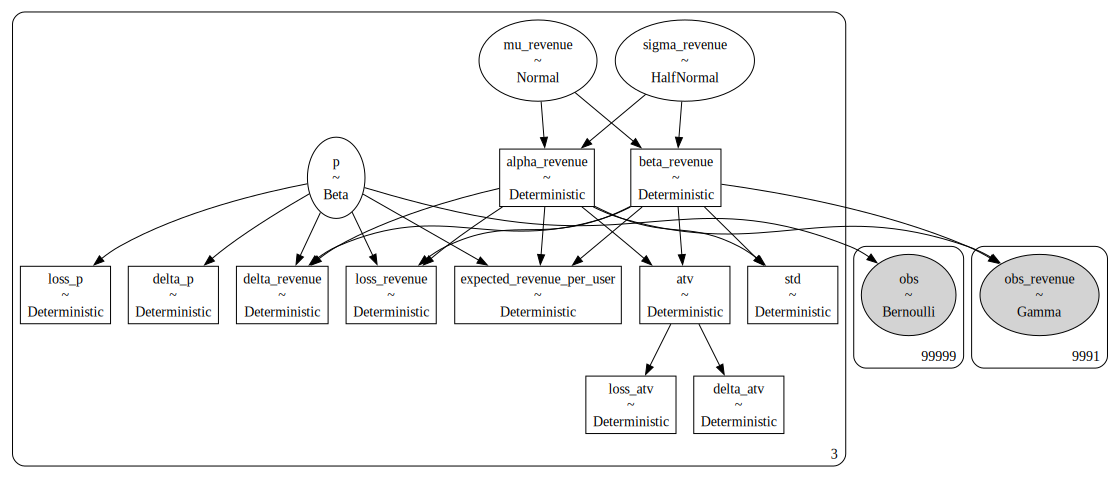

In [15]:
# requires brew/choco install graphviz in your local machine and add python package to pyproject.toml as well
pm.model_to_graphviz(basic_model)

In [16]:
with basic_model:
    # Sample from the posterior
    trace = pm.sample(
        draws=n_draws_per_chain,
        tune=n_tune,
        chains=n_chains,
        cores=n_cores,
        random_seed=RANDOM_SEED,
        progressbar=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [p, mu_revenue, sigma_revenue]


Output()

Sampling 8 chains for 500 tune and 1_000 draw iterations (4_000 + 8_000 draws total) took 429 seconds.


In [17]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>],
       [<Axes: title={'center': 'atv'}>, <Axes: title={'center': 'atv'}>],
       [<Axes: title={'center': 'std'}>, <Axes: title={'center': 'std'}>],
       [<Axes: title={'center': 'expected_revenue_per_user'}>,
        <Axes: title={'center': 'expected_revenue_per_user'}>]],
      dtype=object)

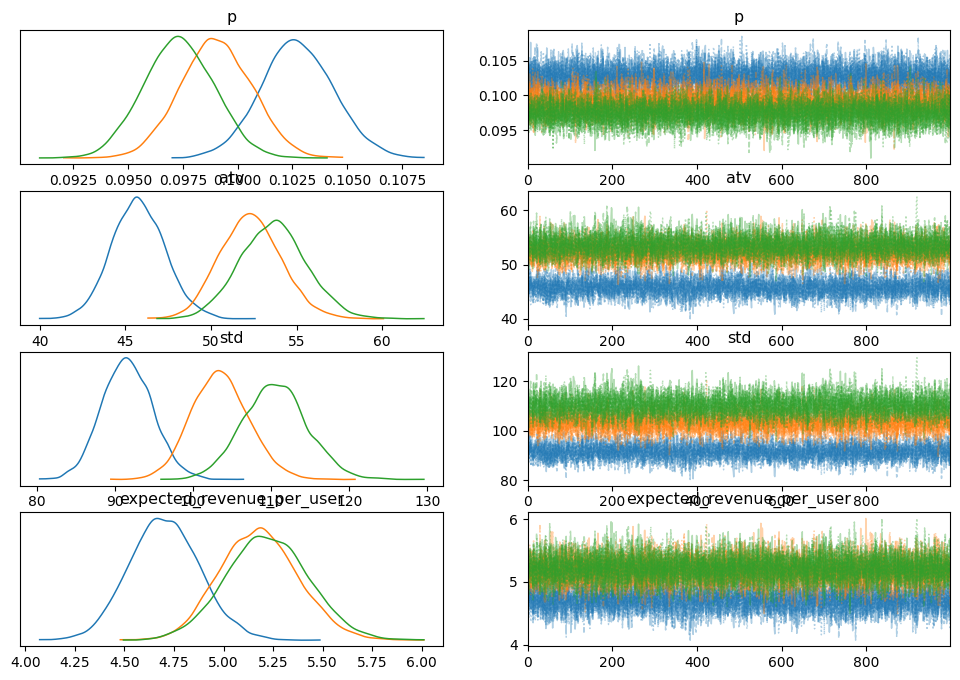

In [18]:
az.plot_trace(trace, combined=True, var_names=['p', 'atv', 'std', 'expected_revenue_per_user'])

array([[<Axes: title={'center': 'mu_revenue'}>,
        <Axes: title={'center': 'mu_revenue'}>],
       [<Axes: title={'center': 'sigma_revenue'}>,
        <Axes: title={'center': 'sigma_revenue'}>],
       [<Axes: title={'center': 'alpha_revenue'}>,
        <Axes: title={'center': 'alpha_revenue'}>],
       [<Axes: title={'center': 'beta_revenue'}>,
        <Axes: title={'center': 'beta_revenue'}>]], dtype=object)

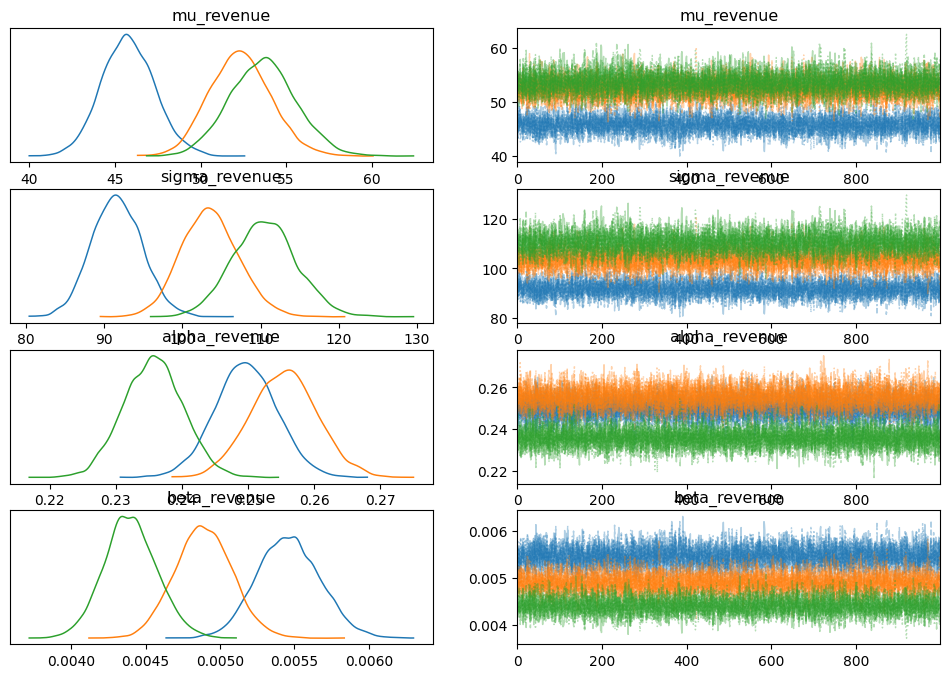

In [41]:
az.plot_trace(trace, combined=True, var_names=['mu_revenue', 'sigma_revenue', 'alpha_revenue', 'beta_revenue'])

array([[<Axes: title={'center': 'delta_p'}>,
        <Axes: title={'center': 'delta_p'}>],
       [<Axes: title={'center': 'loss_p'}>,
        <Axes: title={'center': 'loss_p'}>],
       [<Axes: title={'center': 'delta_revenue'}>,
        <Axes: title={'center': 'delta_revenue'}>],
       [<Axes: title={'center': 'loss_revenue'}>,
        <Axes: title={'center': 'loss_revenue'}>],
       [<Axes: title={'center': 'delta_atv'}>,
        <Axes: title={'center': 'delta_atv'}>],
       [<Axes: title={'center': 'loss_atv'}>,
        <Axes: title={'center': 'loss_atv'}>]], dtype=object)

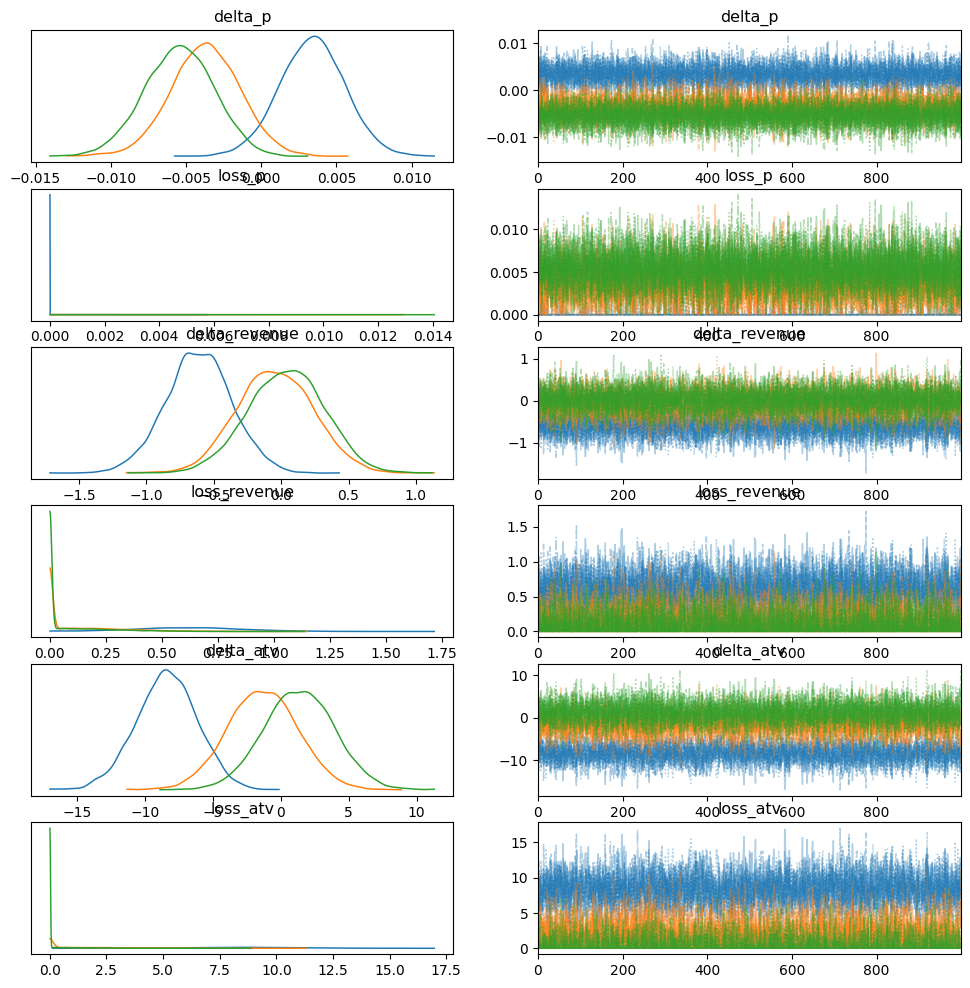

In [20]:
az.plot_trace(trace, combined=True, var_names=['delta_p', 'loss_p', 'delta_revenue', 'loss_revenue', 'delta_atv', 'loss_atv'])

In [21]:
# Analyze the posterior distributions
# Summary statistics
print(az.summary(trace))

                                 mean     sd   hdi_3%  hdi_97%  mcse_mean  \
mu_revenue[0]                  45.770  1.558   42.916   48.803      0.022   
mu_revenue[1]                  52.313  1.785   48.889   55.503      0.024   
mu_revenue[2]                  53.653  1.936   50.024   57.281      0.027   
p[0]                            0.103  0.002    0.100    0.106      0.000   
p[1]                            0.099  0.002    0.096    0.102      0.000   
p[2]                            0.097  0.002    0.094    0.100      0.000   
sigma_revenue[0]               91.616  3.233   85.666   97.711      0.045   
sigma_revenue[1]              103.520  3.675   96.559  110.321      0.050   
sigma_revenue[2]              110.532  4.121  102.806  118.180      0.056   
alpha_revenue[0]                0.250  0.005    0.241    0.259      0.000   
alpha_revenue[1]                0.255  0.005    0.246    0.265      0.000   
alpha_revenue[2]                0.236  0.005    0.227    0.244      0.000   

array([[<Axes: title={'center': 'expected_revenue_per_user\n0'}>,
        <Axes: title={'center': 'expected_revenue_per_user\n1'}>,
        <Axes: title={'center': 'expected_revenue_per_user\n2'}>],
       [<Axes: title={'center': 'p\n0'}>,
        <Axes: title={'center': 'p\n1'}>,
        <Axes: title={'center': 'p\n2'}>],
       [<Axes: title={'center': 'atv\n0'}>,
        <Axes: title={'center': 'atv\n1'}>,
        <Axes: title={'center': 'atv\n2'}>],
       [<Axes: title={'center': 'mu_revenue\n0'}>,
        <Axes: title={'center': 'mu_revenue\n1'}>,
        <Axes: title={'center': 'mu_revenue\n2'}>],
       [<Axes: title={'center': 'std\n0'}>,
        <Axes: title={'center': 'std\n1'}>,
        <Axes: title={'center': 'std\n2'}>],
       [<Axes: title={'center': 'sigma_revenue\n0'}>,
        <Axes: title={'center': 'sigma_revenue\n1'}>,
        <Axes: title={'center': 'sigma_revenue\n2'}>]], dtype=object)

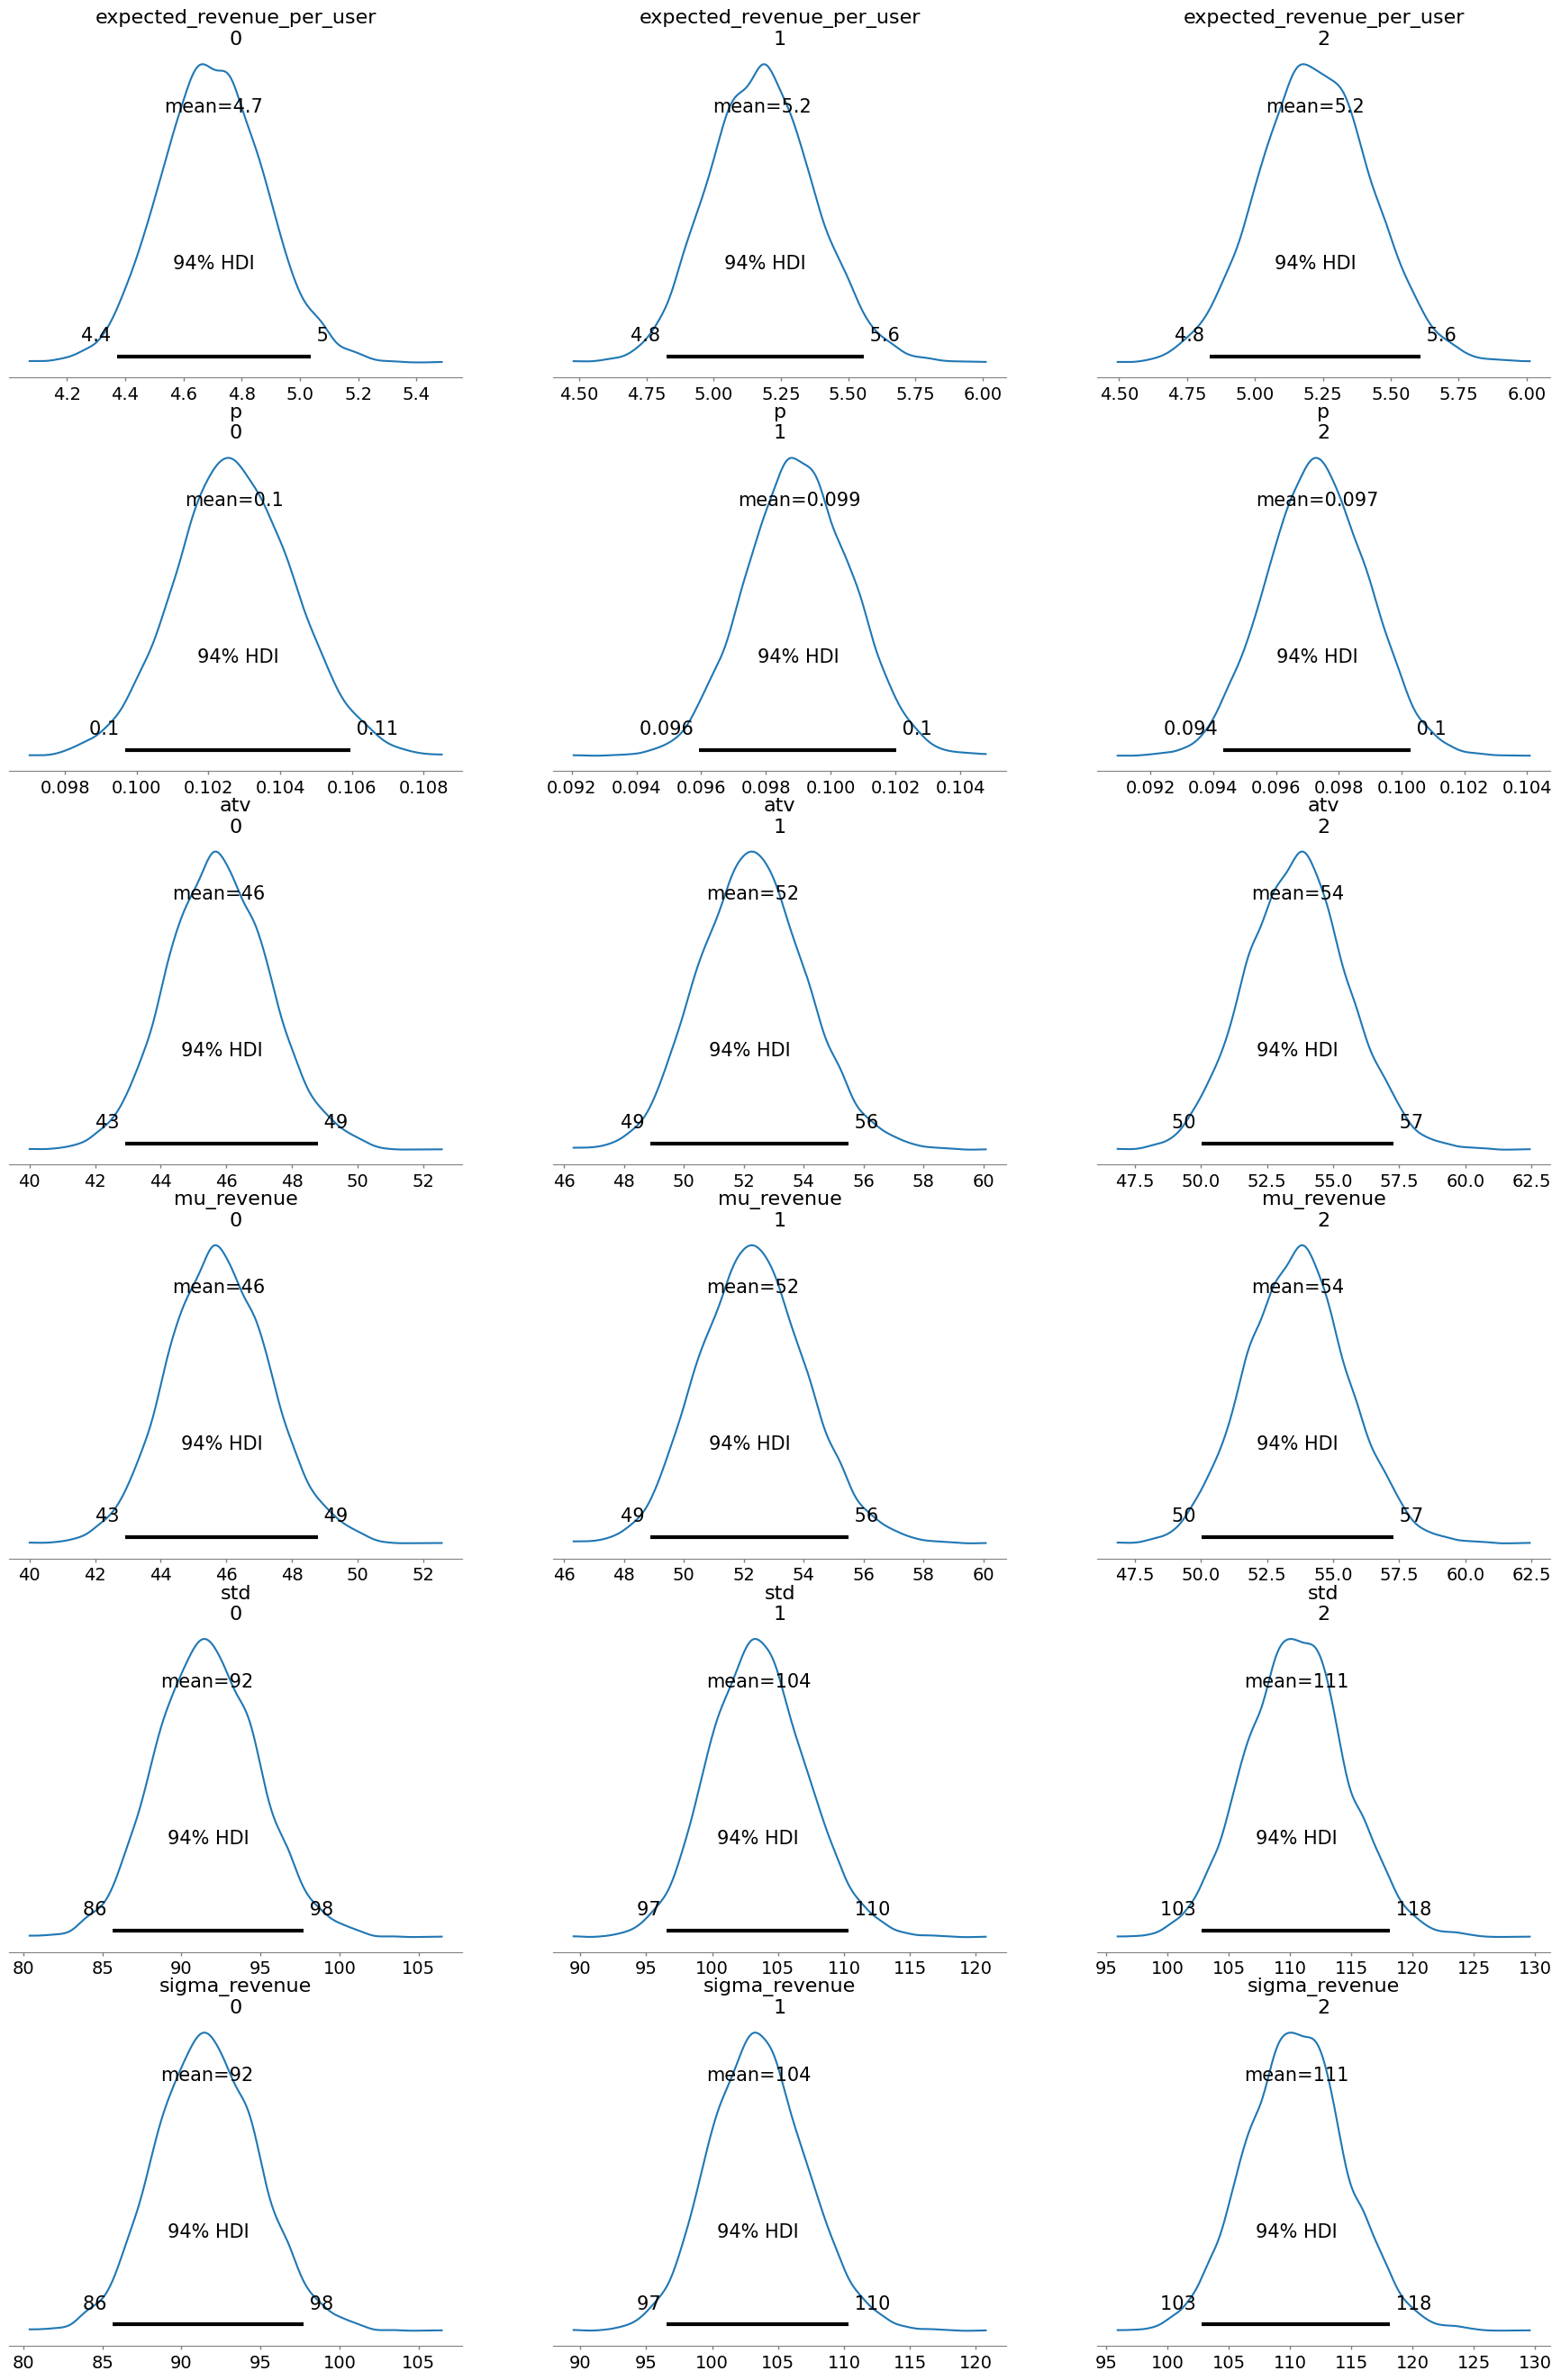

In [43]:
# Plot posterior distributions
az.plot_posterior(trace, var_names=['expected_revenue_per_user', 'p', 'atv', 'mu_revenue', 'std', 'sigma_revenue'])

In [23]:
# Extract posterior samples
delta_p_samples = trace.posterior['delta_p'].values
delta_revenue_samples = trace.posterior['delta_revenue'].values
delta_atv = trace.posterior['delta_atv'].values
loss_p = trace.posterior['loss_p'].values
loss_revenue = trace.posterior['loss_revenue'].values
loss_atv = trace.posterior['loss_atv'].values
atv_samples = trace.posterior['atv'].values
std_samples = trace.posterior['std'].values
alpha_revenue_samples = trace.posterior['alpha_revenue'].values
beta_revenue_samples = trace.posterior['beta_revenue'].values

In [24]:
delta_p_samples.shape, delta_revenue_samples.shape, loss_p.shape, loss_revenue.shape, atv_samples.shape, std_samples.shape, alpha_revenue_samples.shape, beta_revenue_samples.shape

((8, 1000, 3),
 (8, 1000, 3),
 (8, 1000, 3),
 (8, 1000, 3),
 (8, 1000, 3),
 (8, 1000, 3),
 (8, 1000, 3),
 (8, 1000, 3))

Revenue per user:

In [26]:
prob_better_treatment_revenue = np.mean(delta_revenue_samples > 0, axis=(0, 1))
print(f"Probability that treatment is better than the rest: {prob_better_treatment_revenue}")
expected_loss_revenue_per_group = loss_revenue.mean(axis=(0, 1))
print(f"Expected loss if variant is rolled out: {expected_loss_revenue_per_group}")
loss_revenue_ratio = (max(expected_loss_revenue_per_group) + 1e-9) / (expected_loss_revenue_per_group + 1e-9)
print(f"Ratio of expected losses: {loss_revenue_ratio}")

Probability that treatment is better than the rest: [0.0055   0.437875 0.556625]
Expected loss if variant is rolled out: [0.61510327 0.13661103 0.09526587]
Ratio of expected losses: [1.         4.50258859 6.45670138]


Conversion Rate:

In [25]:
prob_better_treatment_p = np.mean(delta_p_samples > 0, axis=(0, 1))
print(f"Probability that treatment is better than the rest: {prob_better_treatment_p}")
expected_loss_p_per_group = loss_p.mean(axis=(0, 1))
print(f"Expected loss if variant is rolled out: {expected_loss_p_per_group}")
loss_p_ratio = (max(expected_loss_p_per_group) + 1e-9) / (expected_loss_p_per_group + 1e-9)
print(f"Ratio of expected losses: {loss_p_ratio}")

Probability that treatment is better than the rest: [0.9405 0.053  0.0065]
Expected loss if variant is rolled out: [5.85208853e-05 3.76040138e-03 5.46300168e-03]
Ratio of expected losses: [93.34973837  1.45277077  1.        ]


Avg. Transaction Value (Revenue per Paying User):

In [27]:
prob_better_treatment_atv = np.mean(delta_atv > 0, axis=(0, 1))
print(f"Probability that treatment is better than the rest: {prob_better_treatment_atv}")
expected_loss_atv_per_group = loss_atv.mean(axis=(0, 1))
print(f"Expected loss if variant is rolled out: {expected_loss_atv_per_group}")
loss_atv_ratio = (max(expected_loss_atv_per_group) + 1e-9) / (expected_loss_atv_per_group + 1e-9)
print(f"Ratio of expected losses: {loss_atv_ratio}")

Probability that treatment is better than the rest: [0.       0.304375 0.695625]
Expected loss if variant is rolled out: [8.38392309 1.84105267 0.50058648]
Ratio of expected losses: [ 1.          4.55387465 16.74820123]


array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

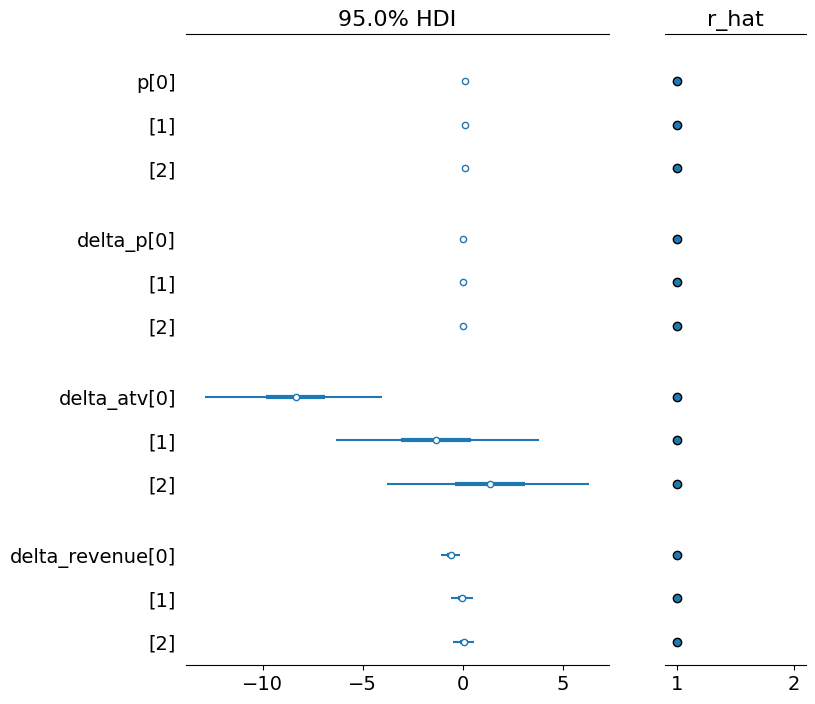

In [28]:
az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=['p', 'delta_p', 'delta_atv', 'delta_revenue'])

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

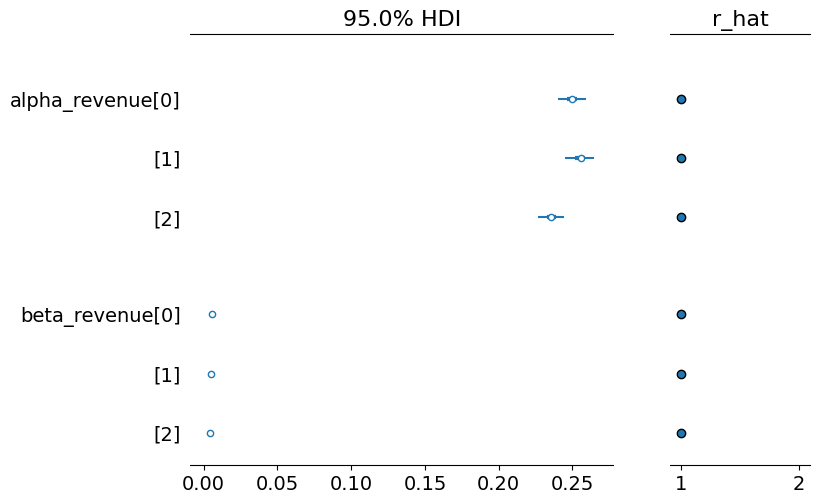

In [45]:
az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=['alpha_revenue', 'beta_revenue'])

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

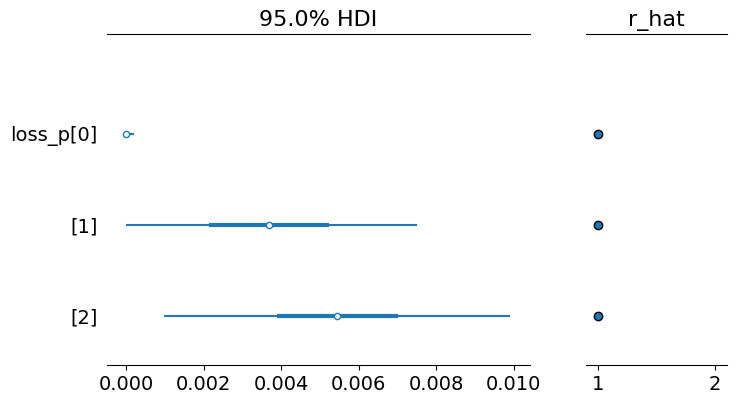

In [30]:
az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=['loss_p'])

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

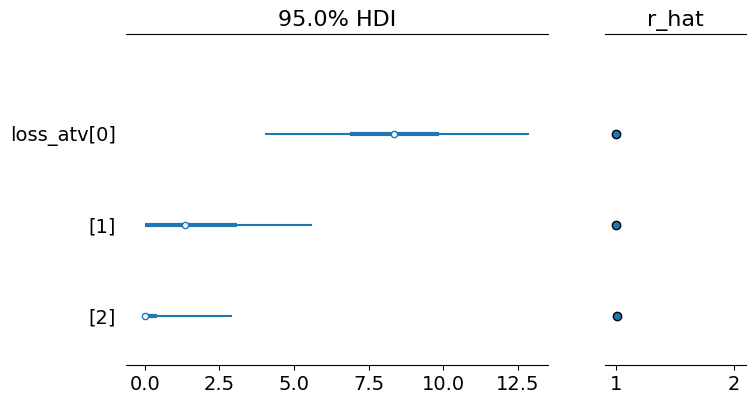

In [31]:
az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=['loss_atv'])

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

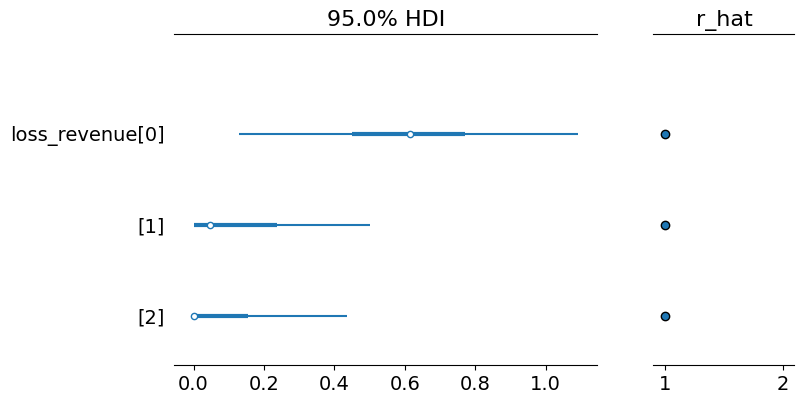

In [32]:
az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=['loss_revenue'])

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

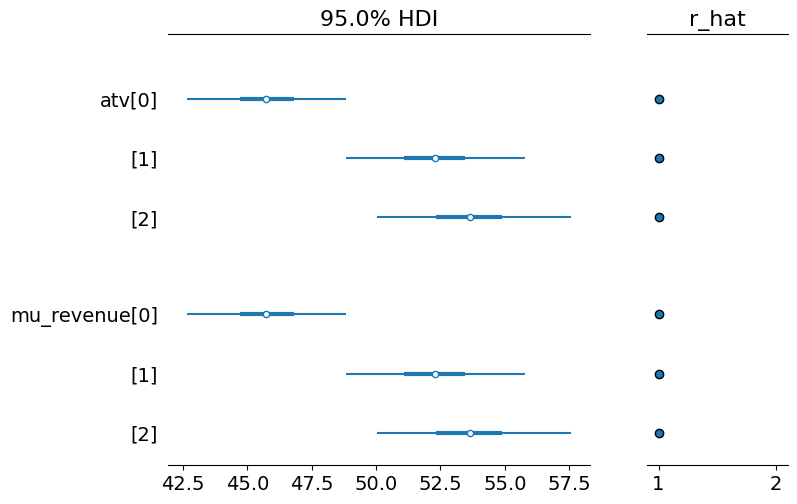

In [46]:
az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=['atv',  'mu_revenue'])

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

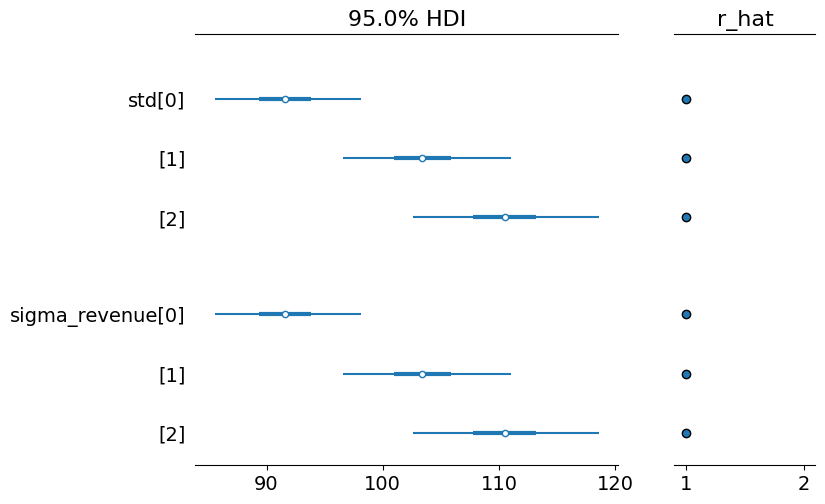

In [47]:
az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=['std', 'sigma_revenue'])

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

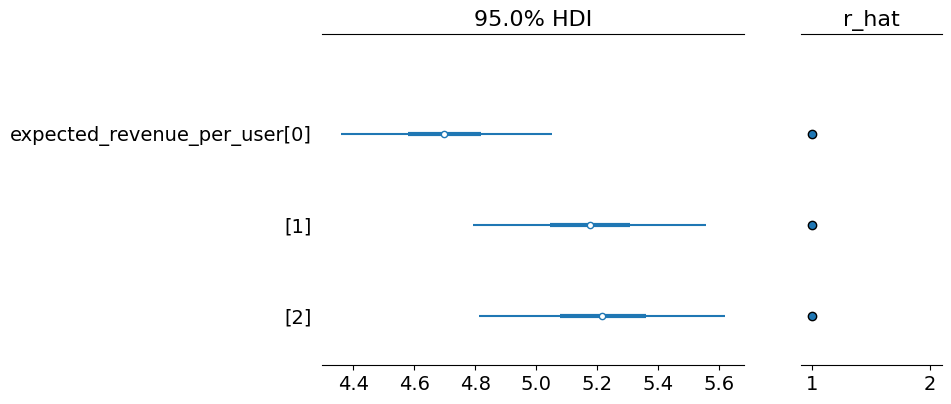

In [35]:
az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=['expected_revenue_per_user'])

<Axes: >

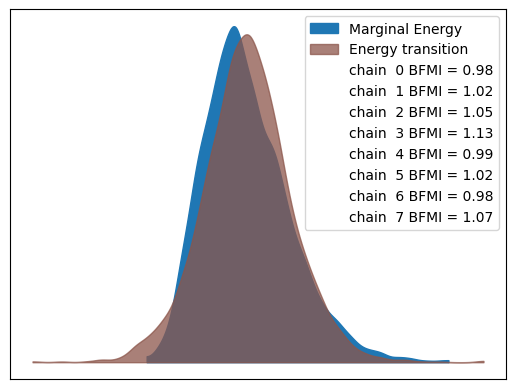

In [36]:
az.plot_energy(trace)

In [37]:
var_name = 'expected_revenue_per_user'

var_samples = trace.posterior[var_name]
dims = [dim for dim in var_samples.dims if dim not in ['chain', 'draw']]  # Get the dimensions of the variable, excluding 'chain' and 'draw'

if len(dims) != 1:
    raise ValueError(f"Expected one non-chain dimension for variable '{var_name}', found {len(dims)} dimensions.")
dim_name = dims[0]  # Get the dimension name
print(dim_name)

for i, group in enumerate(group_labels):

    var_group_samples = var_samples.sel({dim_name: i})
    var_group_mean = var_group_samples.mean(dim=["chain", "draw"]).values
    
    var_group_hpd = az.hdi(var_group_samples, hdi_prob=0.94)
    hdi_lower = var_group_hpd[var_name].sel(hdi='lower').values
    hdi_upper = var_group_hpd[var_name].sel(hdi='higher').values
    
    print(f"Group {group}:")
    print(f"  Mean expected {var_name}: {var_group_mean}")
    print(f"  94% credible interval: [{hdi_lower}, {hdi_upper}]")


expected_revenue_per_user_dim_0
Group control:
  Mean expected expected_revenue_per_user: 4.701719945916186
  94% credible interval: [4.371178417272348, 5.037264789336171]
Group treatment_1:
  Mean expected expected_revenue_per_user: 5.180212183499908
  94% credible interval: [4.8234754235923925, 5.556770270970757]
Group treatment_2:
  Mean expected expected_revenue_per_user: 5.221557345232835
  94% credible interval: [4.835123710819984, 5.6085405163838695]


In [38]:
for i, name in enumerate(group_labels):
    alpha_values_i = trace.posterior['alpha_revenue'].values[:, :, i]
    beta_values_i = trace.posterior['beta_revenue'].values[:, :, i]

    atv_i = atv_samples[:, :, i]
    std_i = std_samples[:, :, i]
    
    print(f"Group {name}:")
    print(f"  Mean alpha: {alpha_values_i.mean()}")
    print(f"  Mean beta: {beta_values_i.mean()}")
    print(f"  Mean atv: {atv_i.mean()}")
    print(f"  Mean std: {std_i.mean()}")
    
    # sanity check that the atv and std values are consistent with the alpha and beta values
    atv_i_from_alpha_beta, std_i_from_alpha_beta = atv_and_std_from_transaction_parameters(alpha_values_i.mean(), beta_values_i.mean())
    print(f"  Mean atv from alpha and beta: {atv_i_from_alpha_beta}")
    print(f"  Mean std from alpha and beta: {std_i_from_alpha_beta}")
    
    # sanity check that the calculation of atv and std from alpha and beta is consistent with the samples
    atv_diff = np.abs(atv_i.mean() - atv_i_from_alpha_beta)
    std_diff = np.abs(std_i.mean() - std_i_from_alpha_beta)
    print(f"  Mean atv diff: {atv_diff}")
    print(f"  Mean std diff: {std_diff}")
    

Group control:
  Mean alpha: 0.24965023196636446
  Mean beta: 0.005460761639555726
  Mean atv: 45.769923878513225
  Mean std: 91.61607324715415
  Mean atv from alpha and beta: 45.71710842641273
  Mean std from alpha and beta: 91.49824557873998
  Mean atv diff: 0.05281545210049643
  Mean std diff: 0.11782766841416503
Group treatment_1:
  Mean alpha: 0.2554436770916132
  Mean beta: 0.004888674920334362
  Mean atv: 52.31279429899872
  Mean std: 103.51963129651064
  Mean atv from alpha and beta: 52.25212992361171
  Mean std from alpha and beta: 103.38473513055365
  Mean atv diff: 0.060664375387005975
  Mean std diff: 0.13489616595698806
Group treatment_2:
  Mean alpha: 0.23568554793596477
  Mean beta: 0.004398454542059252
  Mean atv: 53.65326049173115
  Mean std: 110.53207640198511
  Mean atv from alpha and beta: 53.583718026928246
  Mean std from alpha and beta: 110.37389493796707
  Mean atv diff: 0.06954246480290749
  Mean std diff: 0.15818146401804256


In [39]:
for i, name in enumerate(group_labels):
    atv_i = trace.posterior['atv'].values[:, :, i]
    std_i = trace.posterior['std'].values[:, :, i]
    conversion_rate_i = trace.posterior['p'].values[:, :, i]
    expected_revenue_per_user_i = trace.posterior['expected_revenue_per_user'].values[:, :, i]
    
    print(f"Group {name}:")
    print(f"  Mean atv: {atv_i.mean()}")
    print(f"  Mean std: {std_i.mean()}")
    print(f"  Mean conversion rate: {conversion_rate_i.mean():.4%}")
    print(f"  Std of Conversion rate: {conversion_rate_i.std():.4%}")
    print(f"  Mean expected revenue per user: {expected_revenue_per_user_i.mean()}")
    print(f" Std of expected revenue per user: {expected_revenue_per_user_i.std()}")
    
    # sanity check that the expected revenue per user is consistent with the atv and conversion rate
    expected_revenue_per_user_i_from_atv_and_conversion_rate = atv_i * conversion_rate_i
    expected_revenue_per_user_diff = np.abs(expected_revenue_per_user_i.mean() - expected_revenue_per_user_i_from_atv_and_conversion_rate.mean())
    print(f"  Mean expected revenue per user diff: {expected_revenue_per_user_diff}")


Group control:
  Mean atv: 45.769923878513225
  Mean std: 91.61607324715415
  Mean conversion rate: 10.2725%
  Std of Conversion rate: 0.1657%
  Mean expected revenue per user: 4.701719945916186
 Std of expected revenue per user: 0.17697787326288167
  Mean expected revenue per user diff: 0.0
Group treatment_1:
  Mean atv: 52.31279429899872
  Mean std: 103.51963129651064
  Mean conversion rate: 9.9023%
  Std of Conversion rate: 0.1633%
  Mean expected revenue per user: 5.180212183499908
 Std of expected revenue per user: 0.1970964669110768
  Mean expected revenue per user diff: 0.0
Group treatment_2:
  Mean atv: 53.65326049173115
  Mean std: 110.53207640198511
  Mean conversion rate: 9.7321%
  Std of Conversion rate: 0.1615%
  Mean expected revenue per user: 5.221557345232835
 Std of expected revenue per user: 0.2069030503430053
  Mean expected revenue per user diff: 0.0


In [40]:
import altair as alt
alt.data_transformers.disable_max_rows()

def altair_plot_trace_combined(trace, var_name):
    """
    Creates an Altair chart equivalent to arviz.plot_trace with combined=True for a given variable.

    Parameters:
    - trace: ArviZ InferenceData object containing the posterior samples.
    - var_name: Name of the variable to plot.

    Returns:
    - An Altair chart object displaying the trace plot and posterior distribution.
    """
    # Extract the posterior samples for the variable
    var_samples = trace.posterior[var_name]

    # Combine chains and draws into a single dimension
    combined_samples = var_samples.stack(sample=("chain", "draw"))

    # Corrected line: Remove 'chain' and 'draw' from indexes to avoid conflicts
    combined_samples = combined_samples.reset_index(['chain', 'draw'], drop=True)

    # Identify the variable dimensions excluding 'sample'
    dims = [dim for dim in combined_samples.dims if dim != 'sample']

    # Check if the variable is scalar or has additional dimensions
    if not dims:
        # Scalar variable
        # Convert to pandas DataFrame
        df = combined_samples.to_dataframe(name=var_name).reset_index()

        # Trace plot
        trace_plot = alt.Chart(df).mark_line().encode(
            x=alt.X('sample', title='Sample'),
            y=alt.Y(var_name, title=var_name)
        ).properties(
            width=300,
            height=200,
            title=f'Trace Plot of {var_name}'
        )

        # Posterior distribution plot
        hist_plot = alt.Chart(df).transform_density(
            var_name,
            as_=[var_name, 'density']
        ).mark_area().encode(
            x=alt.X(var_name, title=var_name),
            y=alt.Y('density:Q', title='Density')
        ).properties(
            width=300,
            height=200,
            title=f'Posterior Distribution of {var_name}'
        )

    else:
        # Multidimensional variable
        dim = dims[0]  # Assuming one extra dimension

        # Corrected line: Remove the dimension index to avoid conflicts
        combined_samples = combined_samples.reset_index(dim, drop=True)

        # Convert to pandas DataFrame
        df = combined_samples.to_dataframe(name=var_name).reset_index()

        # Trace plot
        trace_plot = alt.Chart(df).mark_line().encode(
            x=alt.X('sample', title='Sample'),
            y=alt.Y(var_name, title=var_name),
            color=alt.Color(f'{dim}:N', title=dim)
        ).properties(
            width=300,
            height=200,
            title=f'Trace Plot of {var_name}'
        )

        # Posterior distribution plot
        hist_plot = alt.Chart(df).transform_density(
            var_name,
            groupby=[dim],
            as_=[var_name, 'density']
        ).mark_area().encode(
            x=alt.X(var_name, title=var_name),
            y=alt.Y('density:Q', title='Density'),
            color=alt.Color(f'{dim}:N', title=dim)
        ).properties(
            width=300,
            height=200,
            title=f'Posterior Distribution of {var_name}'
        )

    # Concatenate the trace plot and posterior plot side by side
    combined_chart = alt.hconcat(trace_plot, hist_plot).resolve_scale(
        color='independent'
    )

    return combined_chart

# Variable name you want to plot
var_name = 'expected_revenue_per_user'

# Call the function to create the chart
chart = altair_plot_trace_combined(trace, var_name)

# Display the chart
chart.show()  # If running in a Jupyter notebook


alt.HConcatChart(...)